<a href="https://colab.research.google.com/github/aldysp34/Music-Classification-and-Recommendation/blob/master/music_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Model Machine Learning Klasfikasi dan Sistem Rekomendasi Musik**
_Oleh :_
1. *M299R5310 - Muhammad Aldi Surya Putra*
2. *M014V6060 - Ayu Kadek Nadya Oktaviana*

## **1. Download Dataset**

In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od 
od.download("https://www.kaggle.com/andradaolteanu/gtzan-dataset-music-genre-classification")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: aldysp34
Your Kaggle Key: ··········


100%|██████████| 1.21G/1.21G [00:08<00:00, 150MB/s]


## **2. Import Library**

In [3]:
# Usual Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os
import scipy
import pickle

# Audio Library
import librosa
import librosa.display
import IPython.display as ipd

# Classification Library
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Warning Ignore
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Inisialisasi Path Dataset
general_path = '/content/gtzan-dataset-music-genre-classification/Data'

# List Genre Dataset
print(list(os.listdir(f'{general_path}/genres_original/')))

['metal', 'classical', 'country', 'disco', 'reggae', 'hiphop', 'rock', 'pop', 'blues', 'jazz']


## **3. Explore Data Audio**

In [5]:
# Analisis satu sampel audio
data , sr = librosa.load(f'{general_path}/genres_original/pop/pop.00003.wav')

# Cek tipe data
print(type(data), type(sr))

<class 'numpy.ndarray'> <class 'int'>


In [6]:
# Keterangan audio
print('Data\t\t\t: ', data)
print('Data Shape\t\t: ', np.shape(data))
print('Sample Rate (KHz)\t: ', sr)

# Panjang audio
print('\nPanjang Audio\t\t:', librosa.get_duration(data))

Data			:  [-0.0249939  -0.01815796 -0.02023315 ... -0.36505127 -0.4237976
 -0.42385864]
Data Shape		:  (661504,)
Sample Rate (KHz)	:  22050

Panjang Audio		: 30.00018140589569


In [7]:
# Memutar audio
ipd.Audio(data, rate=sr)

### **3.1 _Audio Representation_**

#### **1. Sound Waves**

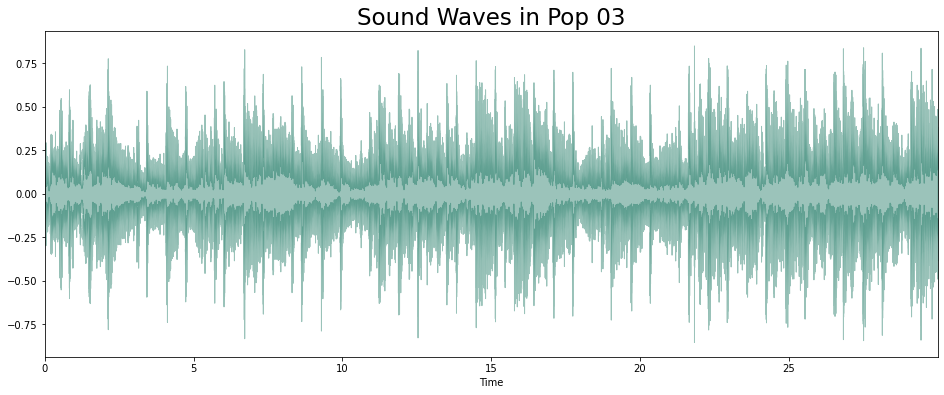

In [8]:
# Waveform Audio
plt.figure(figsize = (16, 6))
librosa.display.waveplot(y = data, sr = sr, alpha = 0.4, color = "#066B54");
plt.title("Sound Waves in Pop 03", fontsize = 23);

#### **2. Spectogram**

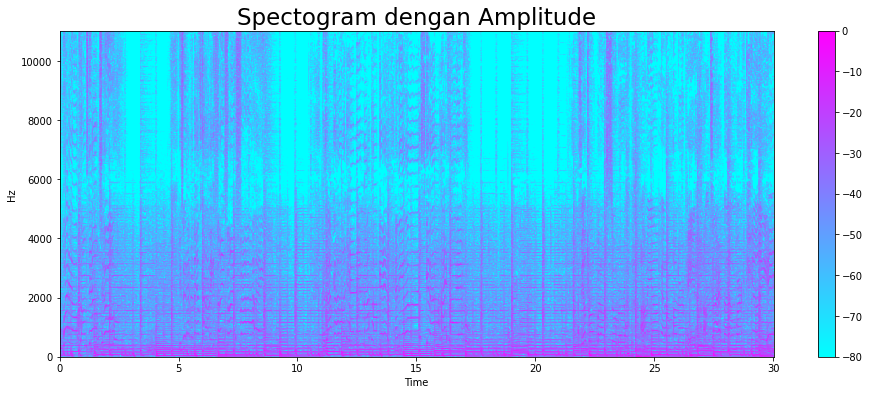

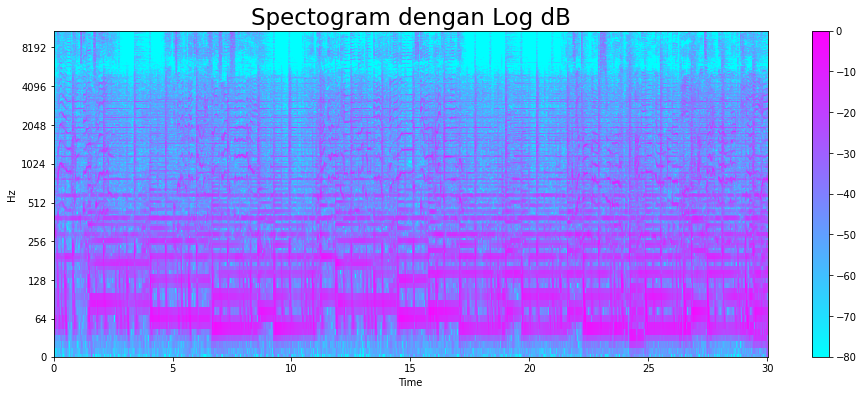

In [9]:
# Short-time Fourier Transform (STFT)
stft = librosa.stft(data, n_fft=2048, hop_length=512)

# Konversi amplitude spectogram menjadi dB-scaled spectogram
stft_db = librosa.amplitude_to_db(stft, ref = np.max)

# Menampilkan spectogram dengan amplitude
plt.figure(figsize = (16, 6))
librosa.display.specshow(stft_db, sr = sr, x_axis = 'time', y_axis = 'hz', cmap ='cool')

plt.colorbar()
plt.title("Spectogram dengan Amplitude", fontsize = 23)
plt.show()

# Menampilkan spectogram dengan log dB
plt.figure(figsize = (16, 6))
librosa.display.specshow(stft_db, sr = sr, x_axis = 'time', y_axis = 'log', cmap ='cool')

plt.colorbar()
plt.title("Spectogram dengan Log dB", fontsize = 23)
plt.show()

#### **3. Mel Spectogram**

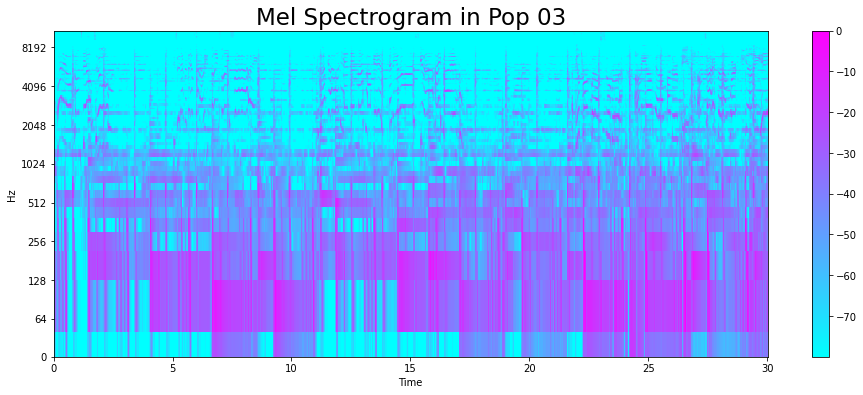

In [10]:
# Konversi mel spectogram
Mel = librosa.feature.melspectrogram(data, sr = sr)
Mel_dB = librosa.amplitude_to_db(Mel, ref = np.max)

# Menampilkan Mel Spectogram
plt.figure(figsize = (16, 6))
librosa.display.specshow(Mel_dB, sr = sr, x_axis = 'time', y_axis = 'log', cmap = 'cool');

plt.colorbar();
plt.title("Mel Spectrogram in Pop 03", fontsize = 23);

### **3.2 _Audio Features_**

#### **1. Tempo BMP (Beats Per Minute)**

In [11]:
# Tempo BPM
tempo, _ = librosa.beat.beat_track(data, sr = sr)
tempo

92.28515625

#### **2. Spectral Features**

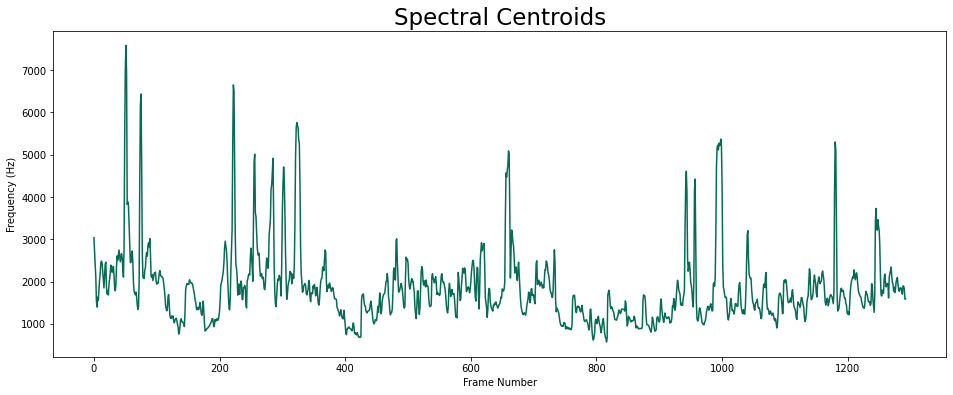

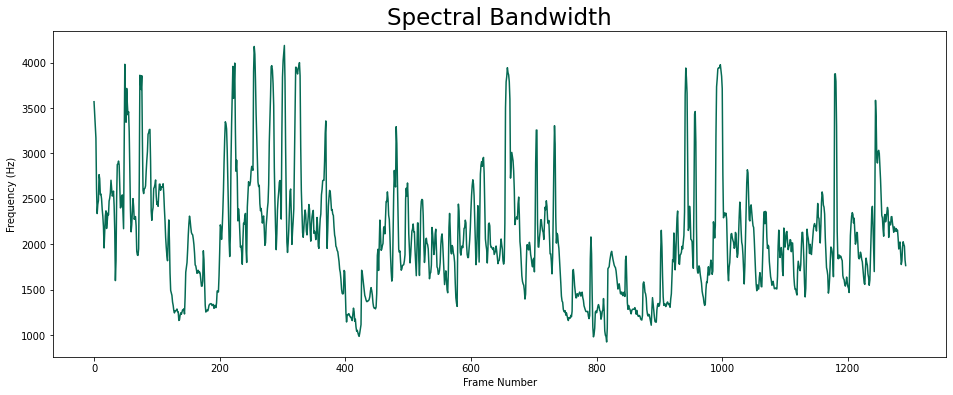

In [12]:
# Spectral Centroids
plt.figure(figsize = (16, 6))
plt.plot(librosa.feature.spectral_centroid(data, sr = sr)[0], color = "#066B54")
plt.xlabel('Frame Number')
plt.ylabel('Frequency (Hz)')
plt.title('Spectral Centroids', fontsize = 23)
plt.show()

# Spectral Bandwith
plt.figure(figsize = (16, 6))
spec_bw = librosa.feature.spectral_bandwidth(data, sr = sr)[0]
plt.xlabel('Frame Number')
plt.ylabel('Frequency (Hz)')
plt.title('Spectral Bandwidth', fontsize = 23)
plt.plot(spec_bw, color = "#066B54")
plt.show()

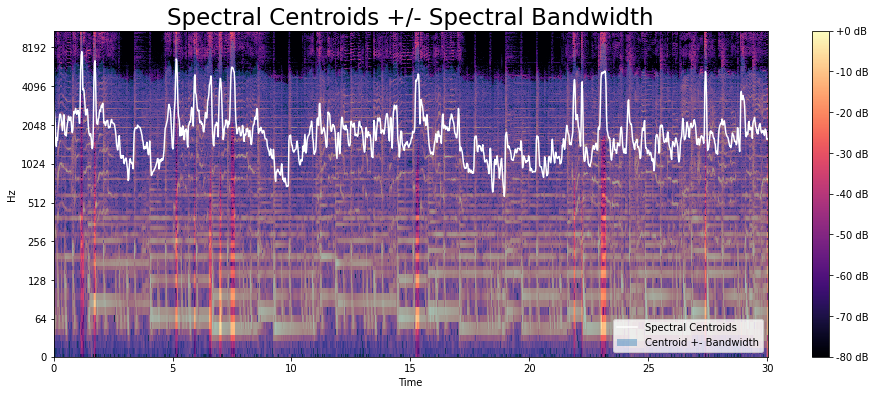

In [13]:
# Visualisasi 
times = librosa.times_like(spec_bw)
centroid = librosa.feature.spectral_centroid(S = np.abs(stft))

fig, ax = plt.subplots(figsize=(16,6))
img = librosa.display.specshow(stft_db, x_axis = 'time',
                         y_axis = 'log', sr = sr, ax = ax)

fig.colorbar(img, ax=ax, format='%+1.0f dB')
plt.title('Spectral Centroids +/- Spectral Bandwidth', fontsize = 23)

ax.fill_between(times, centroid[0] - spec_bw[0], centroid[0] + spec_bw[0],
                alpha =0.4, label = 'Centroid +- Bandwidth')

ax.plot(times, centroid[0], label = 'Spectral Centroids', color = 'w')
ax.legend(loc='lower right')

[Text(0, 0.5, 'Frequency Bands')]

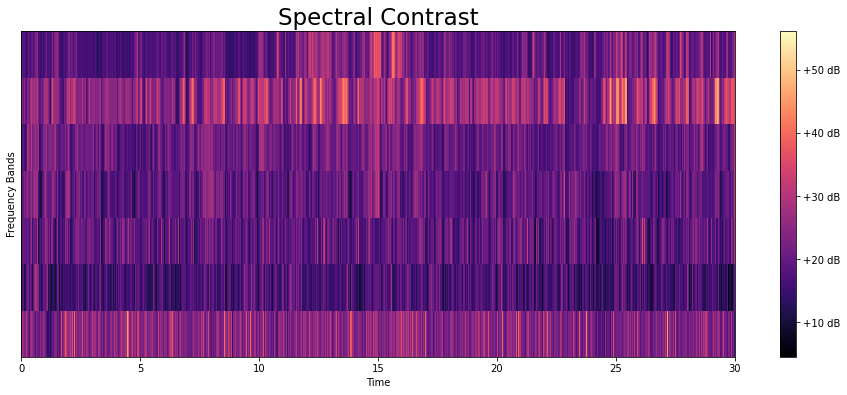

In [14]:
# Spectral Contrast
contrast = librosa.feature.spectral_contrast(S = np.abs(stft), sr = sr)

fig, ax = plt.subplots(figsize=(16,6))
img2 = librosa.display.specshow(contrast, x_axis = 'time', ax = ax)
fig.colorbar(img2, ax = ax, format = '%+1.0f dB')
plt.title('Spectral Contrast', fontsize = 23)
ax.set(ylabel = 'Frequency Bands')

#### **3. Mel-Frequency Cepstral Coefficients (MFCC)**

MFCC Shape	: (20, 1293)


Text(0.5, 1.0, 'MFCC')

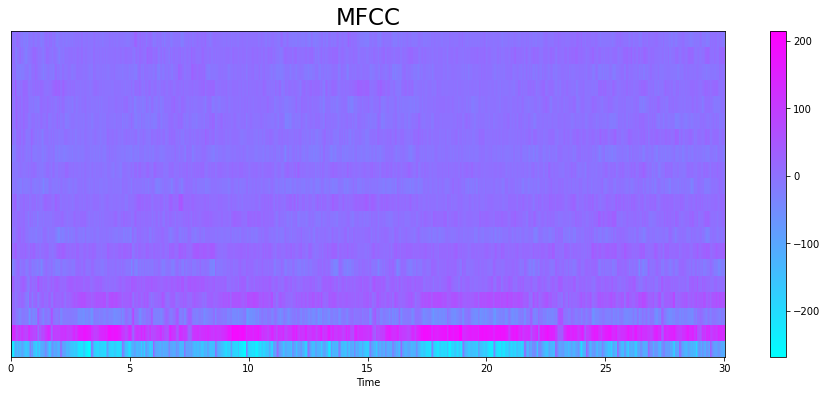

In [15]:
# Konversi ke MFCC
mfccs = librosa.feature.mfcc(data, sr = sr)
print('MFCC Shape\t:', mfccs.shape)

# Menampilkan MFCCs
fig, ax = plt.subplots(figsize = (16, 6))
img = librosa.display.specshow(mfccs, x_axis = 'time', ax = ax, cmap = 'cool')
fig.colorbar(img, ax=ax)
plt.title('MFCC', fontsize = 23)

#### **5. Chroma Feature**

Chromagram Shape	: (12, 1293)


Text(0.5, 1.0, 'Chromagram')

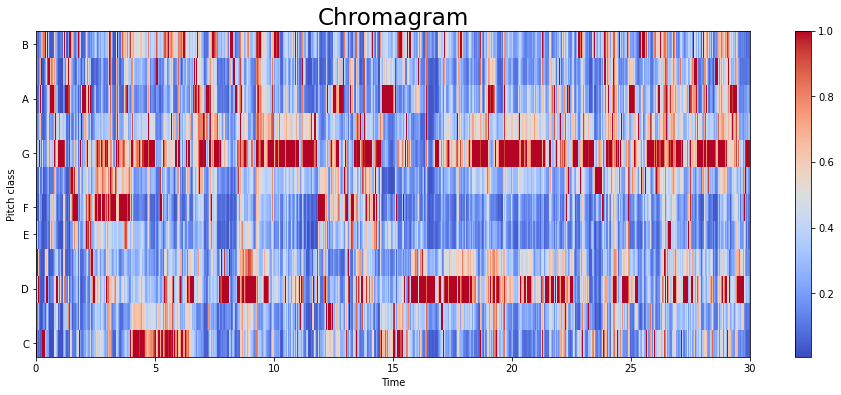

In [16]:
# Chromogram
chromagram = librosa.feature.chroma_stft(y=data, sr = sr)
print('Chromagram Shape\t:', chromagram.shape)

# Menampilkan Chromagram
fig, ax = plt.subplots(figsize=(16, 6))
img = librosa.display.specshow(chromagram, x_axis = 'time', y_axis = 'chroma', cmap = 'coolwarm')
fig.colorbar(img, ax=ax)
plt.title('Chromagram', fontsize = 23)

## **4. Exploratory Data Analysis**

### **4.1 Data Understanding**

In [17]:
# Read data
df = pd.read_csv(f'{general_path}/features_30_sec.csv')
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,3805.839606,9.015054e+05,0.083045,0.000767,-4.529724e-05,0.008172,0.000008,0.005698,123.046875,-113.570648,2564.207520,121.571793,295.913818,-19.168142,235.574432,42.366421,151.106873,-6.364664,167.934799,18.623499,89.180840,-13.704891,67.660492,15.343150,68.932579,-12.274110,82.204201,10.976572,63.386311,-8.326573,61.773094,8.803792,51.244125,-3.672300,41.217415,5.747995,40.554478,-5.162882,49.775421,0.752740,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,3550.522098,2.977893e+06,0.056040,0.001448,1.395807e-04,0.005099,-0.000178,0.003063,67.999589,-207.501694,7764.555176,123.991264,560.259949,8.955127,572.810913,35.877647,264.506104,2.907320,279.932922,21.510466,156.477097,-8.560436,200.849182,23.370686,142.555954,-10.099661,166.108521,11.900497,104.358612,-5.555639,105.173630,5.376327,96.197212,-2.231760,64.914291,4.220140,73.152534,-6.012148,52.422142,0.927998,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,3042.260232,7.840345e+05,0.076291,0.001007,2.105576e-06,0.016342,-0.000019,0.007458,161.499023,-90.722595,3319.044922,140.446304,508.765045,-29.093889,411.781219,31.684334,144.090317,-13.984504,155.493759,25.764742,74.548401,-13.664875,106.981827,11.639934,106.574875,-11.783643,65.447945,9.718760,67.908859,-13.133803,57.781425,5.791199,64.480209,-8.907628,60.385151,-1.077000,57.711136,-9.229274,36.580986,2.451690,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,2184.745799,1.493194e+06,0.033309,0.000423,4.583644e-07,0.019054,-0.000014,0.002712,63.024009,-199.544205,5507.517090,150.090897,456.505402,5.662678,257.161163,26.859079,158.267303,1.771399,268.034393,14.234031,126.794128,-4.832006,155.912079,9.286494,81.273743,-0.759186,92.114090,8.137607,71.314079,-3.200653,110.236687,6.079319,48.251999,-2.480174,56.799400,-1.079305,62.289902,-2.870789,51.651592,0.780874,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,3579.757627,1.572978e+06,0.101461,0.001954,-1.756129e-05,0.004814,-0.000010,0.003094,135.999178,-160.337708,5195.291992,126.219635,853.784729,-35.587811,333.792938,22.148071,193.456100,-32.478600,336.276825,10.852294,134.831573,-23.352329,93.257095,0.498434,124.672127,-11.793437,130.073349,1.207256,99.675575,-13.088418,80.254066,-2.813867,86.430626,-6.933385,89.555443,-7.552725,70.943336,-9.164666,75.793404,-4.520576,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [18]:
# Menemukan data kosong
print("Kolom dengan nilai Null :", list(df.columns[df.isnull().any()]))

Kolom dengan nilai Null : []


In [19]:
# Informasi kolom pada dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 1000 non-null   object 
 1   length                   1000 non-null   int64  
 2   chroma_stft_mean         1000 non-null   float64
 3   chroma_stft_var          1000 non-null   float64
 4   rms_mean                 1000 non-null   float64
 5   rms_var                  1000 non-null   float64
 6   spectral_centroid_mean   1000 non-null   float64
 7   spectral_centroid_var    1000 non-null   float64
 8   spectral_bandwidth_mean  1000 non-null   float64
 9   spectral_bandwidth_var   1000 non-null   float64
 10  rolloff_mean             1000 non-null   float64
 11  rolloff_var              1000 non-null   float64
 12  zero_crossing_rate_mean  1000 non-null   float64
 13  zero_crossing_rate_var   1000 non-null   float64
 14  harmony_mean             

### **4.2 Box Plot untuk Distribusi Genre**

Text(0, 0.5, 'BPM')

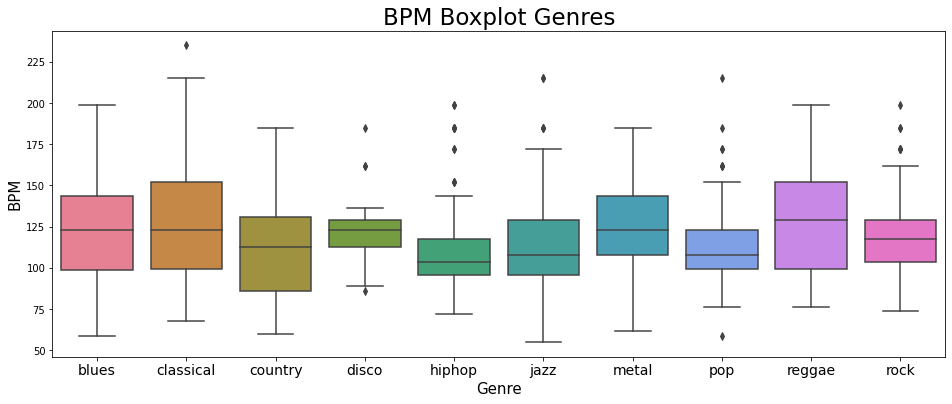

In [20]:
# Box-Plot Genre
x = df[["label", "tempo"]]

f, ax = plt.subplots(figsize=(16, 6));
sns.boxplot(x = "label", y = "tempo", data = x, palette = 'husl');

plt.title('BPM Boxplot Genres', fontsize = 23)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 15)
plt.ylabel("BPM", fontsize = 15)

## **5. Klasifikasi Genre**

### **5.1 Data Preparation**

#### **5.1.1 Menghapus Kolom Yang Tidak Diperlukan**

In [21]:
fix_df = df.drop(['filename', 'length'], axis=1)
fix_df.head()

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,3805.839606,9.015054e+05,0.083045,0.000767,-4.529724e-05,0.008172,0.000008,0.005698,123.046875,-113.570648,2564.207520,121.571793,295.913818,-19.168142,235.574432,42.366421,151.106873,-6.364664,167.934799,18.623499,89.180840,-13.704891,67.660492,15.343150,68.932579,-12.274110,82.204201,10.976572,63.386311,-8.326573,61.773094,8.803792,51.244125,-3.672300,41.217415,5.747995,40.554478,-5.162882,49.775421,0.752740,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,3550.522098,2.977893e+06,0.056040,0.001448,1.395807e-04,0.005099,-0.000178,0.003063,67.999589,-207.501694,7764.555176,123.991264,560.259949,8.955127,572.810913,35.877647,264.506104,2.907320,279.932922,21.510466,156.477097,-8.560436,200.849182,23.370686,142.555954,-10.099661,166.108521,11.900497,104.358612,-5.555639,105.173630,5.376327,96.197212,-2.231760,64.914291,4.220140,73.152534,-6.012148,52.422142,0.927998,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,3042.260232,7.840345e+05,0.076291,0.001007,2.105576e-06,0.016342,-0.000019,0.007458,161.499023,-90.722595,3319.044922,140.446304,508.765045,-29.093889,411.781219,31.684334,144.090317,-13.984504,155.493759,25.764742,74.548401,-13.664875,106.981827,11.639934,106.574875,-11.783643,65.447945,9.718760,67.908859,-13.133803,57.781425,5.791199,64.480209,-8.907628,60.385151,-1.077000,57.711136,-9.229274,36.580986,2.451690,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,2184.745799,1.493194e+06,0.033309,0.000423,4.583644e-07,0.019054,-0.000014,0.002712,63.024009,-199.544205,5507.517090,150.090897,456.505402,5.662678,257.161163,26.859079,158.267303,1.771399,268.034393,14.234031,126.794128,-4.832006,155.912079,9.286494,81.273743,-0.759186,92.114090,8.137607,71.314079,-3.200653,110.236687,6.079319,48.251999,-2.480174,56.799400,-1.079305,62.289902,-2.870789,51.651592,0.780874,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,3579.757627,1.572978e+06,0.101461,0.001954,-1.756129e-05,0.004814,-0.000010,0.003094,135.999178,-160.337708,5195.291992,126.219635,853.784729,-35.587811,333.792938,22.148071,193.456100,-32.478600,336.276825,10.852294,134.831573,-23.352329,93.257095,0.498434,124.672127,-11.793437,130.073349,1.207256,99.675575,-13.088418,80.254066,-2.813867,86.430626,-6.933385,89.555443,-7.552725,70.943336,-9.164666,75.793404,-4.520576,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


#### **5.1.2 Encoding Genre Label**

In [22]:
label_index = dict()
index_label = dict()
for i, x in enumerate(fix_df.label.unique()):
    label_index[x] = i
    index_label[i] = x
print(label_index)
print(index_label)

{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
{0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}


In [23]:
fix_df.label = [label_index[l] for l in df.label]

#### **5.1.3 Mendefinisikan Atribut dan Label**

In [24]:
fix_df_y = fix_df.pop('label')
fix_df_X = fix_df

In [25]:
# fix_df.drop(columns='label', axis=1, inplace=True)

In [26]:
# fix_df_X = fix_df
# fix_df_y = pd.DataFrame(label.toarray(), columns=label_encoder.categories_)
# fix_df = fix_df.join(pd.DataFrame(label.toarray(), columns=label_encoder.categories_))

In [27]:
fix_df.head()

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,3805.839606,9.015054e+05,0.083045,0.000767,-4.529724e-05,0.008172,0.000008,0.005698,123.046875,-113.570648,2564.207520,121.571793,295.913818,-19.168142,235.574432,42.366421,151.106873,-6.364664,167.934799,18.623499,89.180840,-13.704891,67.660492,15.343150,68.932579,-12.274110,82.204201,10.976572,63.386311,-8.326573,61.773094,8.803792,51.244125,-3.672300,41.217415,5.747995,40.554478,-5.162882,49.775421,0.752740,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035
1,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,3550.522098,2.977893e+06,0.056040,0.001448,1.395807e-04,0.005099,-0.000178,0.003063,67.999589,-207.501694,7764.555176,123.991264,560.259949,8.955127,572.810913,35.877647,264.506104,2.907320,279.932922,21.510466,156.477097,-8.560436,200.849182,23.370686,142.555954,-10.099661,166.108521,11.900497,104.358612,-5.555639,105.173630,5.376327,96.197212,-2.231760,64.914291,4.220140,73.152534,-6.012148,52.422142,0.927998,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282
2,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,3042.260232,7.840345e+05,0.076291,0.001007,2.105576e-06,0.016342,-0.000019,0.007458,161.499023,-90.722595,3319.044922,140.446304,508.765045,-29.093889,411.781219,31.684334,144.090317,-13.984504,155.493759,25.764742,74.548401,-13.664875,106.981827,11.639934,106.574875,-11.783643,65.447945,9.718760,67.908859,-13.133803,57.781425,5.791199,64.480209,-8.907628,60.385151,-1.077000,57.711136,-9.229274,36.580986,2.451690,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025
3,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,2184.745799,1.493194e+06,0.033309,0.000423,4.583644e-07,0.019054,-0.000014,0.002712,63.024009,-199.544205,5507.517090,150.090897,456.505402,5.662678,257.161163,26.859079,158.267303,1.771399,268.034393,14.234031,126.794128,-4.832006,155.912079,9.286494,81.273743,-0.759186,92.114090,8.137607,71.314079,-3.200653,110.236687,6.079319,48.251999,-2.480174,56.799400,-1.079305,62.289902,-2.870789,51.651592,0.780874,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339
4,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,3579.757627,1.572978e+06,0.101461,0.001954,-1.756129e-05,0.004814,-0.000010,0.003094,135.999178,-160.337708,5195.291992,126.219635,853.784729,-35.587811,333.792938,22.148071,193.456100,-32.478600,336.276825,10.852294,134.831573,-23.352329,93.257095,0.498434,124.672127,-11.793437,130.073349,1.207256,99.675575,-13.088418,80.254066,-2.813867,86.430626,-6.933385,89.555443,-7.552725,70.943336,-9.164666,75.793404,-4.520576,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160


In [28]:
fix_df_X.head()

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,3805.839606,9.015054e+05,0.083045,0.000767,-4.529724e-05,0.008172,0.000008,0.005698,123.046875,-113.570648,2564.207520,121.571793,295.913818,-19.168142,235.574432,42.366421,151.106873,-6.364664,167.934799,18.623499,89.180840,-13.704891,67.660492,15.343150,68.932579,-12.274110,82.204201,10.976572,63.386311,-8.326573,61.773094,8.803792,51.244125,-3.672300,41.217415,5.747995,40.554478,-5.162882,49.775421,0.752740,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035
1,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,3550.522098,2.977893e+06,0.056040,0.001448,1.395807e-04,0.005099,-0.000178,0.003063,67.999589,-207.501694,7764.555176,123.991264,560.259949,8.955127,572.810913,35.877647,264.506104,2.907320,279.932922,21.510466,156.477097,-8.560436,200.849182,23.370686,142.555954,-10.099661,166.108521,11.900497,104.358612,-5.555639,105.173630,5.376327,96.197212,-2.231760,64.914291,4.220140,73.152534,-6.012148,52.422142,0.927998,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282
2,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,3042.260232,7.840345e+05,0.076291,0.001007,2.105576e-06,0.016342,-0.000019,0.007458,161.499023,-90.722595,3319.044922,140.446304,508.765045,-29.093889,411.781219,31.684334,144.090317,-13.984504,155.493759,25.764742,74.548401,-13.664875,106.981827,11.639934,106.574875,-11.783643,65.447945,9.718760,67.908859,-13.133803,57.781425,5.791199,64.480209,-8.907628,60.385151,-1.077000,57.711136,-9.229274,36.580986,2.451690,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025
3,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,2184.745799,1.493194e+06,0.033309,0.000423,4.583644e-07,0.019054,-0.000014,0.002712,63.024009,-199.544205,5507.517090,150.090897,456.505402,5.662678,257.161163,26.859079,158.267303,1.771399,268.034393,14.234031,126.794128,-4.832006,155.912079,9.286494,81.273743,-0.759186,92.114090,8.137607,71.314079,-3.200653,110.236687,6.079319,48.251999,-2.480174,56.799400,-1.079305,62.289902,-2.870789,51.651592,0.780874,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339
4,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,3579.757627,1.572978e+06,0.101461,0.001954,-1.756129e-05,0.004814,-0.000010,0.003094,135.999178,-160.337708,5195.291992,126.219635,853.784729,-35.587811,333.792938,22.148071,193.456100,-32.478600,336.276825,10.852294,134.831573,-23.352329,93.257095,0.498434,124.672127,-11.793437,130.073349,1.207256,99.675575,-13.088418,80.254066,-2.813867,86.430626,-6.933385,89.555443,-7.552725,70.943336,-9.164666,75.793404,-4.520576,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160


In [29]:
fix_df_y

0      0
1      0
2      0
3      0
4      0
      ..
995    9
996    9
997    9
998    9
999    9
Name: label, Length: 1000, dtype: int64

In [30]:
fix_df_X.shape

(1000, 57)

In [31]:
fix_df_y.shape

(1000,)

#### **5.1.4 Splitting Data Train dan Test**

In [32]:
X_train, X_test, y_train, y_test = train_test_split(fix_df_X, fix_df_y, train_size=0.8)

In [33]:
print(f"X_train ada {X_train.shape[0]}")
print(f"X_test ada {X_test.shape[0]}")
print(f"y_train ada {y_train.shape[0]}")
print(f"y_test ada {y_test.shape[0]}")

X_train ada 800
X_test ada 200
y_train ada 800
y_test ada 200


#### **5.1.5 Scaling Data Atribut**

In [34]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [35]:
X_train

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,0.406615,0.038895,0.719583,-0.115580,1.547114,0.200875,0.995991,-0.002255,1.246880,0.139556,2.082326,0.476166,0.119748,0.131213,-0.748233,0.657428,-0.066387,1.162069,-0.975369,-1.546028,-0.425871,0.044557,-0.343753,-0.877925,-0.348947,0.763251,-0.940162,0.312602,-0.492853,1.212442,-0.689289,-0.324219,-0.828041,0.934890,-1.038405,0.443204,-0.560149,0.631808,-0.883330,-0.409740,-0.706318,0.338661,-0.771192,-0.602264,-0.618805,0.043561,-0.540137,-0.195330,0.002894,0.750030,0.856256,0.553377,0.553297,-0.285566,0.049792,0.281511,0.258216
1,-0.867266,-0.757220,-0.390600,-0.703768,0.564357,-0.442464,0.524199,-0.808038,0.698355,-0.908967,0.639061,-0.060785,0.195704,-0.398180,0.190154,-0.674694,-0.566085,0.274974,-1.120316,-0.397570,-0.916730,0.685170,-0.794175,0.548373,-1.167014,-3.067610,-0.947691,0.539401,-0.969317,-2.177777,-1.201869,0.358500,-0.727946,-1.251614,-1.131180,-0.310639,-0.949965,-1.443900,-0.884230,-0.059699,-0.774187,-3.743581,-0.799396,0.277639,-0.627925,-2.496939,-0.761697,2.157238,-0.289252,-1.909044,-0.851868,0.599371,-0.879551,-2.933846,-0.829925,-0.833165,-0.583612
2,-0.989106,1.439641,0.255658,-0.407408,0.160841,0.183292,0.712704,-0.397168,0.399325,-0.068734,-0.698844,0.327810,0.092744,0.289876,-0.713509,-0.409777,-1.275335,0.259296,-0.767683,-0.666794,-0.605257,0.624977,-0.435514,-0.089500,-0.255215,1.444660,-0.747404,-0.103603,-0.638434,1.158330,-0.867689,-0.003619,-0.799628,0.604758,0.058889,-0.098400,-0.534145,-0.046720,-0.661366,-0.620345,-0.477254,-0.352967,-0.104879,-0.008358,-0.413279,0.419980,-0.581825,-0.397753,-0.681040,-0.200681,-0.779250,-0.199029,-0.678526,-0.814844,-0.601145,-0.207202,-0.207636
3,1.093455,-0.554659,-1.079740,-0.768886,1.087047,0.943939,0.978842,1.497640,1.035032,0.949183,0.915523,0.708158,0.221726,-0.881160,0.399563,-0.743471,-0.066387,-0.034250,-0.739633,-1.031973,0.059721,0.085414,0.054977,-0.239055,-0.378853,0.596403,-0.046123,-0.178311,-0.135028,1.439826,-0.312595,0.017775,0.577658,1.308568,-0.593463,0.373235,-0.014983,1.017399,-0.538453,0.497537,-0.155314,0.573548,-0.477748,-0.984235,-0.791101,-0.763348,-0.691831,-0.148424,-0.445827,-0.033750,-0.586411,0.199937,-0.464943,0.999913,-0.557007,1.733449,-0.425546
4,-0.233516,0.678722,-1.147820,-0.673637,-0.299880,-0.539647,-0.185636,-0.496540,-0.191462,-0.406087,-0.227815,-0.353177,-0.284845,-0.859452,-0.609733,-0.795054,-1.754557,-0.546799,-0.600461,0.299269,-0.440751,-0.315824,-0.999744,0.498712,-1.272389,-0.799858,-1.144431,0.373754,-1.107556,-0.616539,-1.071851,0.792204,-1.172198,-1.457238,-1.304184,0.449682,-1.034718,-0.876562,-1.093337,0.384329,-1.254172,-1.145466,-1.144000,1.076926,-0.906008,-1.089949,-0.779597,1.940398,-0.411874,-0.393384,-0.522194,-0.981087,-0.549692,-0.838985,0.117433,0.223136,-0.081859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,1.401103,0.052549,0.559342,-0.353898,0.227137,-0.287826,0.482292,-0.261583,0.391108,-0.418919,-0.796504,-0.640016,0.218138,0.593404,0.278383,-0.291492,-0.707026,0.449461,-0.326659,-0.886063,-0.612550,0.280126,0.053006,0.604559,0.001083,0.550731,-0.219026,0.822876,-0.623052,0.877559,-0.5

### **5.2 Model Building Using Deep Learning**

In [36]:
# Callback Function

class Callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > 0.80 and logs.get('val_accuracy') > 0.80:
      self.model.stop_training = True

my_callback = Callback()

In [48]:
model = Sequential()

model.add(layers.Dense(1024, activation = 'relu', input_shape=(X_train.shape[1],),kernel_initializer="he_normal", kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(10, activation='softmax'))  

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 1024)              59392     
                                                                 
 dropout_8 (Dropout)         (None, 1024)              0         
                                                                 
 dense_10 (Dense)            (None, 512)               524800    
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_11 (Dense)            (None, 256)               131328    
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_12 (Dense)            (None, 128)              

In [53]:
# Compile Model
adam = keras.optimizers.Adam(lr=1e-8)
sgd = tf.keras.optimizers.SGD(lr=0.001, momentum=0.8)
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9),
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

In [54]:
history = model.fit(X_train, y_train,
                 validation_data = (X_test,y_test),
                 epochs = 1000,
                 batch_size=64,
                 callbacks=my_callback)

Epoch 1/1000
13/13 [==============================] - 1s 23ms/step - loss: 0.9329 - accuracy: 0.8813 - val_loss: 1.3477 - val_accuracy: 0.7450
Epoch 2/1000
13/13 [==============================] - 0s 10ms/step - loss: 0.6873 - accuracy: 0.9563 - val_loss: 1.3838 - val_accuracy: 0.7350
Epoch 3/1000
13/13 [==============================] - 0s 10ms/step - loss: 0.6357 - accuracy: 0.9775 - val_loss: 1.3433 - val_accuracy: 0.7400
Epoch 4/1000
13/13 [==============================] - 0s 9ms/step - loss: 0.7227 - accuracy: 0.9337 - val_loss: 1.3756 - val_accuracy: 0.7350
Epoch 5/1000
13/13 [==============================] - 0s 10ms/step - loss: 0.6787 - accuracy: 0.9488 - val_loss: 1.4092 - val_accuracy: 0.7250
Epoch 6/1000
13/13 [==============================] - 0s 10ms/step - loss: 0.6485 - accuracy: 0.9600 - val_loss: 1.4094 - val_accuracy: 0.7050
Epoch 7/1000
13/13 [==============================] - 0s 10ms/step - loss: 0.6652 - accuracy: 0.9563 - val_loss: 1.6463 - val_accuracy: 0.6750


Max. Validation Accuracy 0.800000011920929


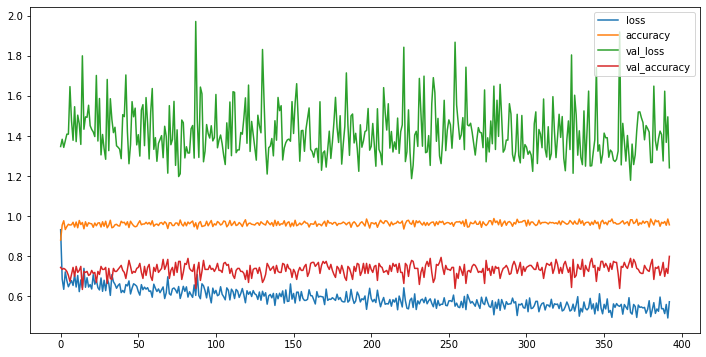

In [55]:
print("Max. Validation Accuracy", max(history.history["val_accuracy"]))
pd.DataFrame(history.history).plot(figsize=(12,6))
plt.show()

### **5.3 Model Evaluation**

In [56]:
test_loss, test_acc  = model.evaluate(X_test, y_test, batch_size=128)
print("Loss Test :", test_loss)
print("Accuracy Test :", test_acc*100)

2/2 [==============================] - 0s 8ms/step - loss: 1.2416 - accuracy: 0.8000
Loss Test : 1.2416294813156128
Accuracy Test : 80.0000011920929


### 5.4 Testing Model